In [1]:
from Scripts.essentials import *
import h5py
from scipy.signal import savgol_filter
from scipy import stats

Available computational components
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12469075219976090036
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 1527425706
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2545716491921274351
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3050 OEM, pci bus id: 0000:01:00.0, compute capability: 8.6"
xla_global_id: 416903419
]


In [2]:
ensemble_model = make_ensemble()
ensemble_model.load_weights(filepath= "Models/ensembleModelRes.h5")

standard_model = make_standard()
standard_model.load_weights(filepath = "Models/standardModel.h5")

cascade = tf.keras.models.load_model("Models/unet_three.23-64.96.h5")

import BartonModel
barton_model = BartonModel.load_model()
barton_model.summary()

img_path = "Figures/LiveCellDenoising/"

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_unnormalized (InputLa  [(None, 600, 1, 1)]      0         
 yer)                                                            
                                                                 
 input_ (Normalization)      (None, 600, 1, 1)         1201      
                                                                 
 conv_1_ (Conv2D)            (None, 600, 1, 256)       2560      
                                                                 
 bnorm_1_ (BatchNormalizatio  (None, 600, 1, 256)      1024      
 n)                                                              
                                                                 
 re_lu (ReLU)                (None, 600, 1, 256)       0         
                                                                 
 conv_2_ (Conv2D)            (None, 600, 1, 128)       1639

In [3]:
# Load the data into memory
data_path = "Data/Live_Cells_Sample/"

data = []
data_names = []
for sample in os.listdir(data_path):
    with h5py.File(data_path + sample) as f:
        #print("Keys:", f.keys())
        regions = f["Regions"]
        
        datasets = []
        for region in list(regions):
            datasets.append(np.array(regions[region]["Dataset"]))
            
        data.append(datasets)
        data_names.append(sample)

In [4]:
for d in range(len(data)):
    concat = np.empty((0, 1738))
    for region in range(len(data[d])):
        data[d][region] = np.array(data[d][region]).reshape((-1), 1738)
        print(data[d][region])
        concat = np.concatenate([concat, data[d][region]], axis = 0)
    data[d] = concat

[[ 85.476  12.044  15.954 ...  87.612  36.42   64.977]
 [ 19.941 -28.508  12.043 ... 143.229 127.071  62.106]
 [144.81    8.543 -58.984 ...  66.044   6.718  90.917]
 ...
 [-16.342 113.352 198.473 ... 128.506  10.967  96.302]
 [ 87.646  63.533 141.232 ... 182.719 114.236  88.874]
 [ 42.298  41.634 150.16  ... 103.938 220.269 113.048]]
[[ 45.363 121.751 161.734 ... 199.217  99.097  65.515]
 [228.286 118.473  54.768 ...  78.686 138.893  81.91 ]
 [104.925 -30.502  35.401 ...  73.541  92.804  44.908]
 ...
 [-12.081  -9.124  84.537 ... 123.999 147.335 145.111]
 [ 64.945  66.046 -39.58  ...  37.948  22.623 103.201]
 [155.938  48.338  61.408 ... 126.861 144.252  51.823]]
[[206.02  173.701 188.076 ...  49.664 146.502 209.737]
 [189.414 179.897 217.523 ... 200.175  96.351 135.413]
 [105.239 149.735 250.579 ... 137.267 298.024 164.439]
 ...
 [165.657 -67.332  48.071 ... 303.444 175.067 257.418]
 [276.067 352.767 377.498 ...  69.95   94.684 221.468]
 [177.722 152.563  60.982 ... 146.055 140.221 10

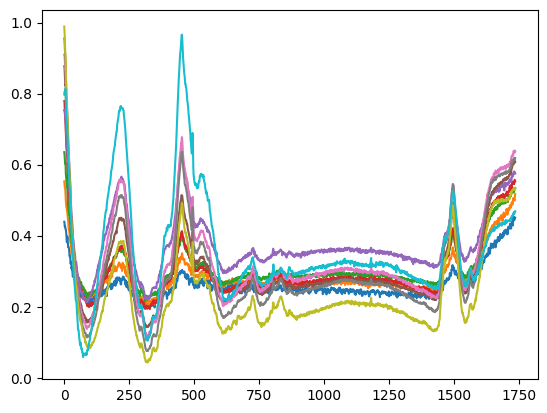

In [5]:
for ix in range(len(data)):
    d = data[ix]
    maxim = np.max(d, axis = 1)
    minim = np.min(d, axis = 1)
    d = (d - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
    data[ix] = d
    plt.plot(np.median(d, axis = 0))
plt.show()

In [6]:
# Define the Signal-to-Noise(SNR) ratio
def SNR(signal, noise, predicted_noise, eps = 0.0001):

    # SSNR from Han et al.
    s = np.mean(signal)
    n = np.std((noise - predicted_noise)) + eps # add eps if noise is 0
    return np.round((s)/(n), 1)

In [7]:
# Locate peaks and appropriate noise regions
signal_regions = [   np.array(range(100, 311)),
                     np.array(range(330, 601)),
                     np.array(range(1430, 1551))
                     ]
    
noise_regions = [
                np.array(range(890, 991)),
                np.array(range(1080, 1181)),
                np.array(range(1240, 1341))
                ]

# Join the region indices into one list and keep an indicator for noise and signal regions
joined_regions = []
noise_signal_indicator = []
i, j = 0, 0

while i < len(noise_regions) or j < len(signal_regions):
    # Append the signal region
    if j == len(signal_regions):
        joined_regions.append(noise_regions[i])
        i += 1
        noise_signal_indicator.append(0)

    elif i == len(noise_regions):
        joined_regions.append(signal_regions[j])
        j += 1
        noise_signal_indicator.append(1)
        
    elif (noise_regions[i][0] < signal_regions[j][0]) :
        joined_regions.append(noise_regions[i])
        i += 1
        noise_signal_indicator.append(0)
    else:
        joined_regions.append(signal_regions[j])
        j += 1
        noise_signal_indicator.append(1)

cell100x0_25sec25slit.h5


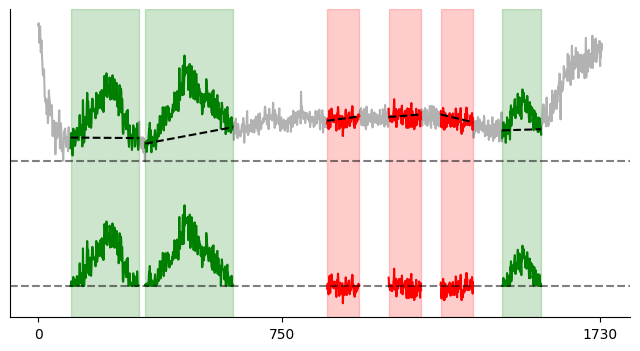

In [8]:
# Plot the noise and signal identification process


fig, ax = plt.subplots(figsize = (8, 4))
print(data_names[6])
spectrum = data[6][0] + 0.9
plt.plot(spectrum, color = "Black", alpha = 0.3)

ax.set_xticks([])
ax.set_yticks([])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

noise = []
signal = []

for region in noise_regions:

    ax.plot(region, spectrum[region], color = "Red")
    ax.plot((region[0], region[-1]), (np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]])), color = "black", linestyle = '--')
    ax.axvspan(region[0], region[-1], color = "red", alpha = 0.2)

    line = np.linspace(np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]]), len(region))

    ax.plot(region, spectrum[region] - line, color = "Red")
    noise = np.concatenate((noise, spectrum[region] - line))
                 
for region in signal_regions:
    l = int(len(region)/2)
    ax.axvspan(region[0], region[-1], color = "green", alpha = 0.2)
    
    ax.plot(region, spectrum[region], color = "Green")
    ax.plot((region[0], region[-1]), (np.median(spectrum[region[:8]]), np.median(spectrum[region[-8:]])), color = "black", linestyle = '--')
    
    line = np.linspace(np.median(spectrum[region][:8]), np.median(spectrum[region][-8:]), len(region))

    ax.plot(region, np.clip(spectrum[region] - line, 0, None), color = "Green")
    signal = np.concatenate(( signal, spectrum[region] - line))

signal = np.ravel(signal)
noise = np.ravel(noise)
ax.set_xticks([0, 750, 1730])
#plt.title("Signal Mean: " + str(np.round(np.mean(signal), 2)) + ", Noise Standard Deviation: " + str(np.round(np.std(noise), 2)))

plt.axhline(y = np.min(spectrum), color = 'black', linestyle = '--', alpha = 0.5) 
plt.axhline(y = 0, color = 'black', linestyle = '--', alpha = 0.5) 

plt.savefig(img_path + "SignalNoisePreparation.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
plt.show()

cell100x0_0025sec25slit.h5
cell100x0_005sec25slit.h5
cell100x0_01sec25slit.h5
cell100x0_025sec25slit.h5
cell100x0_05sec25slit.h5
cell100x0_1sec25slit.h5
cell100x0_25sec25slit.h5
cell100x0_5sec25slit.h5
cell100x1sec25slit.h5
cell100x2sec25slit.h5


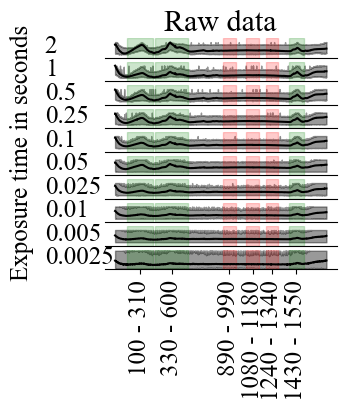

In [9]:
y_labels = []
for y in  data_names:
    print(y)
    y_labels.append(y[8: y.index("s")])
    y_labels[-1] = y_labels[-1].replace("_", ".")


plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

fig, axs = plt.subplots(len(data_names), figsize = (3, 3), sharex=False, sharey=False)
fig.text(-0.15, 0.5, 'Exposure time in seconds', ha='center', va='center', rotation='vertical')
axs[0].set_title("Raw data")

for en, n in enumerate(np.flip(data_names)):
    dn = np.squeeze(np.copy(data[-(en+1)]))
    noises = []
    # Get the noise and signal regions to count the SNR
    for region in noise_regions:
        l = int(len(region)/2)
            # Get noise signal from region
        noise = dn[:, region] 

            # Straighten the noise vector
            # Interpolate a line that goes through the noise vector, from the center of the left to the center of the right end.
        difference = np.linspace(np.median(noise[:, :l], axis = 1), np.median(noise[:, -l:], axis = 1), len(region))

        noise = (noise.T - difference).T
        
            # Center noise signal around mean = 0
        noise = noise - np.expand_dims(np.mean(noise, axis=1), 1)
        noises.append(noise)

    signals = []
    for region in signal_regions:
            
            # Get the signal
        signal = dn[:, region]


        # Remove background influence on peak signal
        difference = np.linspace(np.min(signal[:, :l], axis = 1), np.min(signal[:, -l:], axis = 1), len(region))
        signal = (signal.T - difference).T


        signal = signal - np.expand_dims(np.min(signal, axis=1), 1)
        signals.append(signal)
        
    noises = np.concatenate(noises, axis = 1)
    signals = np.concatenate(signals, axis = 1)

    raw_snrs = []
    for s, n in zip(signals, noises):
        raw_snrs.append(SNR(s, n, 0)) # Raw data SNR
    raw_snr = np.round(np.mean(raw_snrs), 2)

    #axs[en].yaxis.set_label_position("right")
    # Plot the percentiles on each frequency
    axs[en].fill_between(np.arange(1738), np.percentile(dn, 0, axis = 0), np.percentile(dn, 100, axis = 0), alpha = 0.4, color = "Black")
    #axs[en].fill_between(np.arange(1738), np.percentile(dn, 15, axis = 0), np.percentile(dn, 85, axis = 0), alpha = 0.4, color = "Black")
    #axs[en].fill_between(np.arange(1738), np.percentile(dn, 40, axis = 0), np.percentile(dn, 60, axis = 0), alpha = 0.6, color = "Black")
    
    # Plot the mean vector of the data class
    axs[en].plot(np.median(dn, axis = 0), color = "Black")

    for region in noise_regions:
        axs[en].axvspan(region[0], region[-1], color = "red", alpha = 0.2)

    for region in signal_regions:
        axs[en].axvspan(region[0], region[-1], color = "green", alpha = 0.2)

    
    #axs[en].set_ylabel("Time: " + np.flip(y_labels)[en] + "\nSNR: " +str(raw_snr), rotation=0, loc='bottom', labelpad=65)
    axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=43)
    axs[en].set_xticks([])
    axs[en].set_yticks([])
    axs[en].set_ylim(-0.3, 1.3)
    axs[en].spines['left'].set_visible(False)
    axs[en].spines['right'].set_visible(False)
    axs[en].spines['top'].set_visible(False)
    #leg = axs[en].legend(["SNR: " +str(raw_snr)], loc = "upper right", bbox_to_anchor=(1.3, 1.3), fontsize = 8, frameon=False)
    #leg.get_frame().set_linewidth(0.0)
    
plt.autoscale() 
x_ticks = np.ravel([np.mean([np.min(reg), np.max(reg)]) for reg in joined_regions])
x_labels = [str(np.min(reg)) + " - " + str(np.max(reg)) for reg in joined_regions]
plt.xticks(x_ticks, x_labels, rotation = 90)
plt.savefig(img_path + "RawDataDistro.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
plt.show()

cell100x2sec25slit.h5


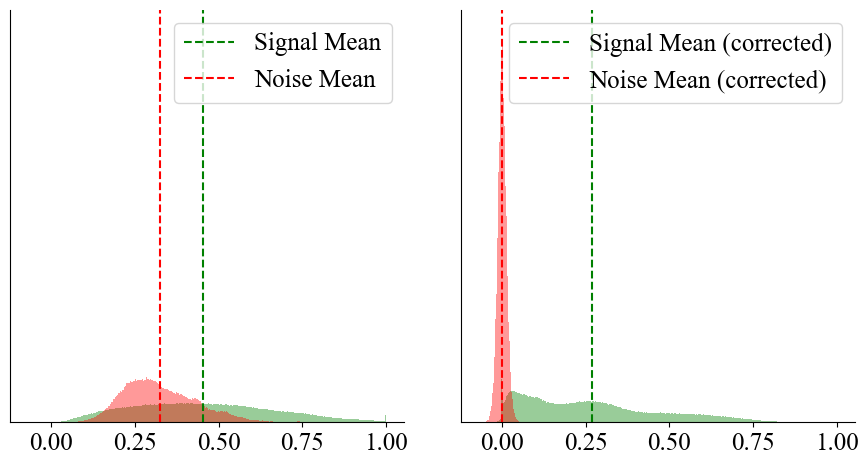

cell100x1sec25slit.h5


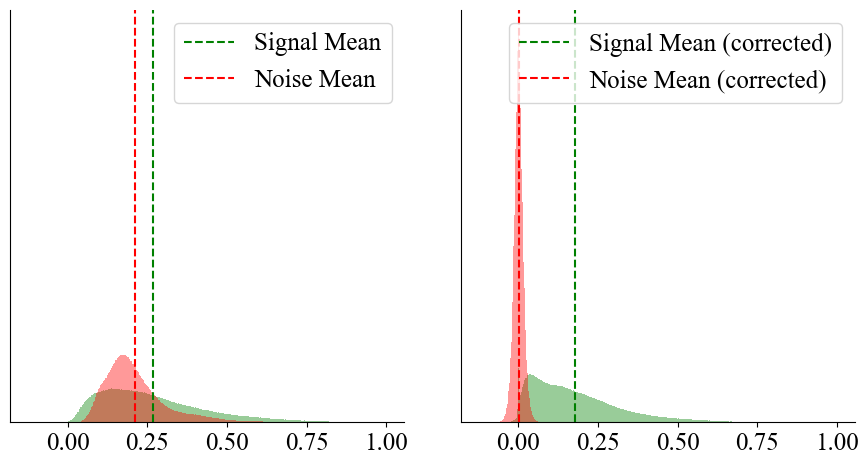

cell100x0_5sec25slit.h5


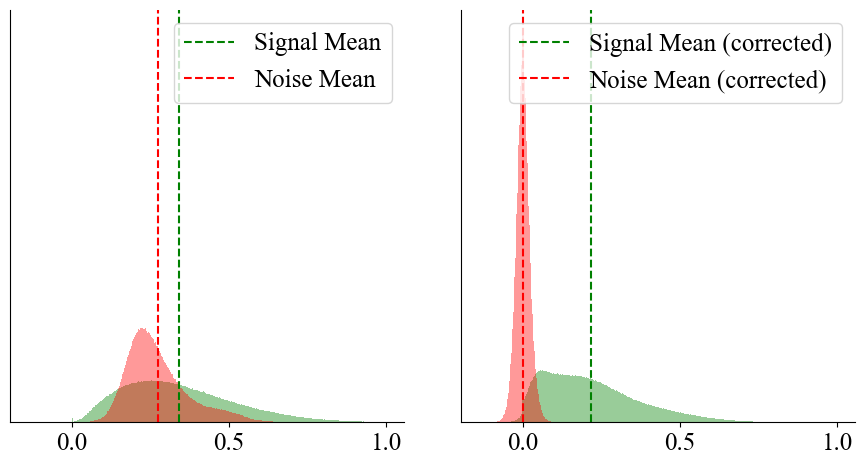

cell100x0_25sec25slit.h5


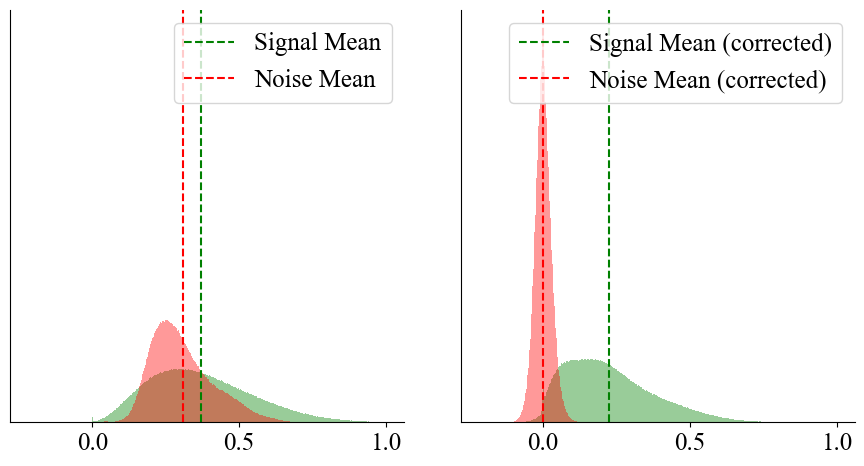

cell100x0_1sec25slit.h5


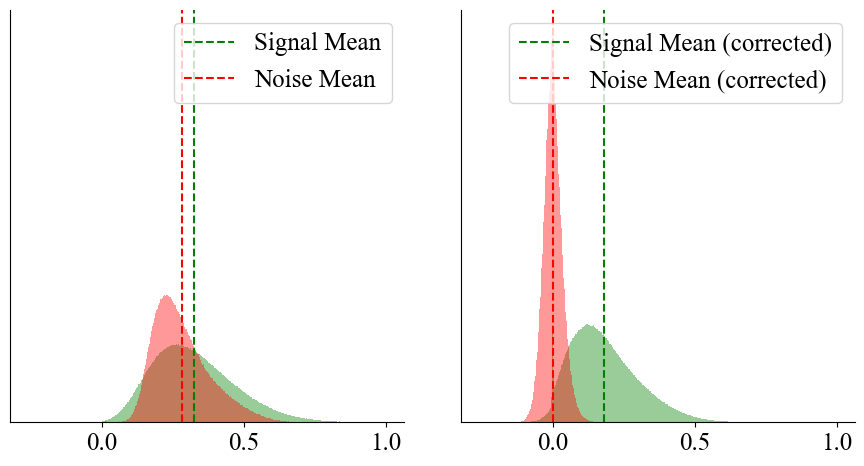

cell100x0_05sec25slit.h5


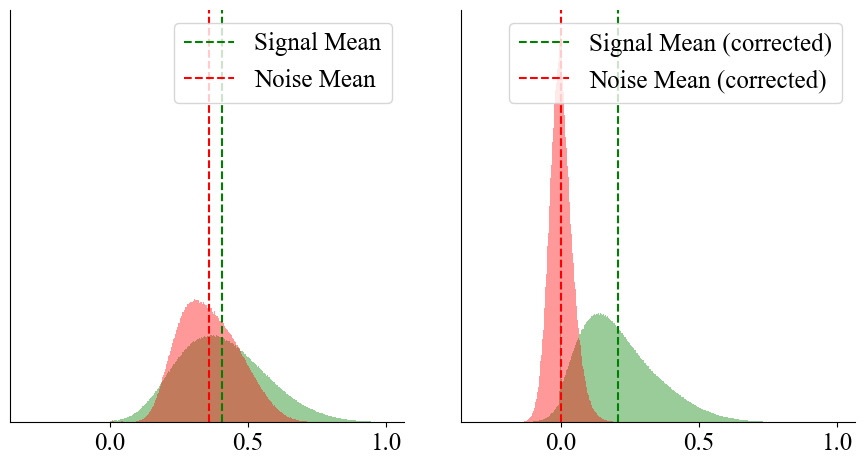

cell100x0_025sec25slit.h5


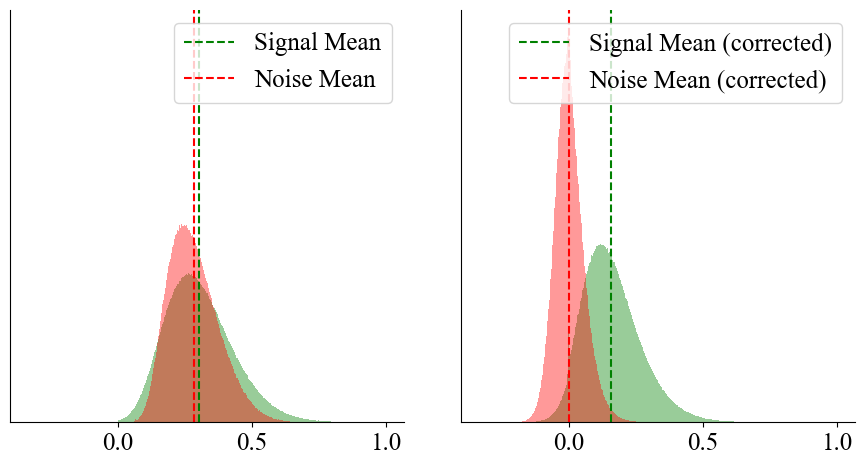

cell100x0_01sec25slit.h5


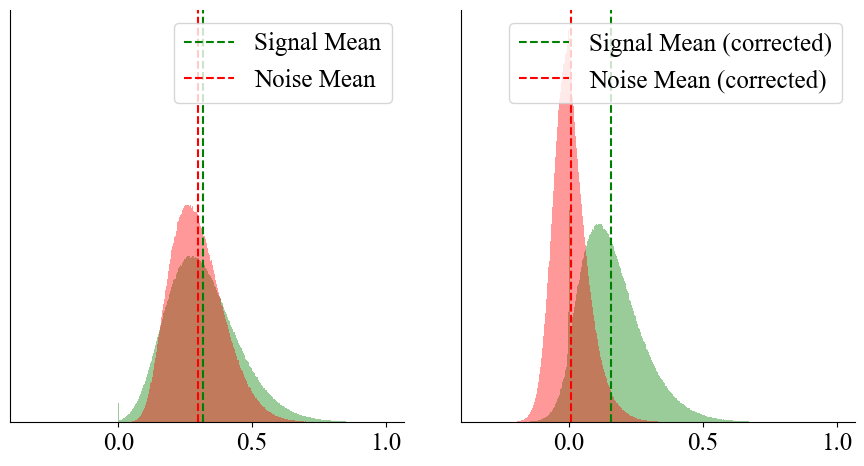

cell100x0_005sec25slit.h5


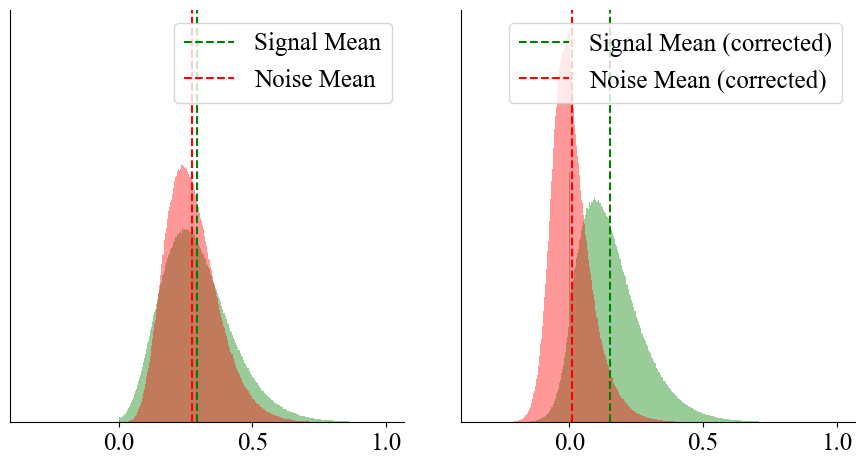

cell100x0_0025sec25slit.h5


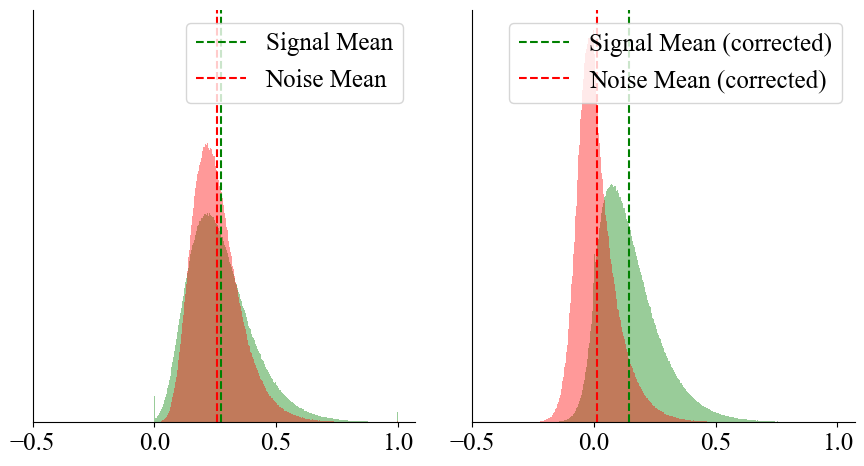

In [10]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"
mean_color = "orangered"
final_p_values = []


for en, n in enumerate(np.flip(data_names)):
    spec = np.squeeze(np.copy(data[-(en+1)])).reshape((-1, 1738))
    shapiro_wilk_p = []
    global_p = []
    fixed = []
    
    noise_fixed = []
    noise_original = []
    signal_fixed = []
    signal_original = []
    print(n)
    
    for reg, indicator in zip(joined_regions, noise_signal_indicator):
        s = spec[:, reg]
        p_vals = []
        if indicator == 0:
            
            line = np.linspace(np.median(spec[:, reg[:8]], axis = 1), np.median(spec[:, reg[-8:]], axis = 1), len(reg))
            
            noise_original.append(s)
            noise = s - line.T# - np.expand_dims(mean, -1)
            fixed.append(noise)
            noise_fixed.append(noise)
            
        else:
            signal_original.append(s)
            
            line = np.linspace(np.min(spec[:, reg[:8]], axis = 1), np.min(spec[:, reg[-8:]], axis = 1), len(reg))
            signal = (s - line.T)
            signal_fixed.append(signal)
            
            fixed.append(signal)

    
    noise_fixed = np.concatenate(noise_fixed, axis = 1)
    noise_original = np.concatenate(noise_original, axis = 1)
    signal_fixed = np.concatenate(signal_fixed, axis = 1)
    signal_original = np.concatenate(signal_original, axis = 1)

    fig, ax = plt.subplots(1, 2, figsize = (9, 5), sharex = True, sharey = True)
    ax[0].hist(np.ravel(signal_original)[:], density = True, color = "Green", alpha = 0.4,
                      bins=500)
    ax[0].axvline(np.mean(np.ravel(signal_original)[:]), color = "Green", label = "Signal Mean", linestyle="--")
    ax[0].hist(np.ravel(noise_original)[:], density = True, color = "Red", alpha = 0.4,
                      bins=500)
    ax[0].axvline(np.mean(np.ravel(noise_original)[:]), color = "Red", label = "Noise Mean", linestyle="--")

    
    #ax[0].set_xticks([-1, 0, 1])
    ax[0].set_yticks([])
    ax[0].spines['right'].set_visible(False)
    ax[0].spines['top'].set_visible(False)
    ax[0].legend(loc = "upper right")

    ax[1].hist(np.ravel(signal_fixed)[:], density = True, color = "Green", alpha = 0.4,
                      bins=500)
    ax[1].axvline(np.mean(np.ravel(signal_fixed)[:]), color = "Green", label = "Signal Mean (corrected)", linestyle="--")
    ax[1].hist(np.ravel(noise_fixed)[:], density = True, color = "Red", alpha = 0.4,
                      bins=500)
    ax[1].axvline(np.mean(np.ravel(noise_fixed)[:]), color = "Red", label = "Noise Mean (corrected)", linestyle="--")
    #ax[1].set_xticks([-1, 0, 1])
    ax[1].set_yticks([])
    ax[1].spines['right'].set_visible(False)
    ax[1].spines['top'].set_visible(False)
    ax[1].legend(loc = "upper right")

    fig.tight_layout()
    plt.savefig(img_path + n + "NoiseDistributions.pdf", format="pdf", dpi=1200, bbox_inches = "tight")
    plt.show()


In [11]:
ensemble_preds = {}
standard_preds = {}

ensemble_components = {}
standard_components = {}

# Extract the noise from the spectra using our models
for d, n in zip(data, data_names):
    print(n) # Print the data name and exposure time info

        # Get the predictions
    ensemble_comp = ensemble_model.predict(np.expand_dims(d, -1))
    standard_comp = standard_model.predict(np.expand_dims(d, -1))
    
        # Add predictions to a dictionary
    ensemble_preds[n] = ensemble_comp[2]
    standard_preds[n] = standard_comp[2]

    ensemble_components[n] = ensemble_comp
    standard_components[n] = standard_comp

    


cell100x0_0025sec25slit.h5
281/281 [==============================] - 21s 73ms/step
cell100x0_005sec25slit.h5
275/275 [==============================] - 20s 73ms/step
cell100x0_01sec25slit.h5
330/330 [==============================] - 24s 74ms/step
cell100x0_025sec25slit.h5
351/351 [==============================] - 26s 74ms/step
cell100x0_05sec25slit.h5
262/262 [==============================] - 19s 74ms/step
cell100x0_1sec25slit.h5
241/241 [==============================] - 18s 73ms/step
cell100x0_25sec25slit.h5
203/203 [==============================] - 15s 74ms/step
cell100x0_5sec25slit.h5
171/171 [==============================] - 13s 74ms/step
cell100x1sec25slit.h5
179/179 [==============================] - 13s 73ms/step
cell100x2sec25slit.h5
47/47 [==============================] - 3s 73ms/step


In [12]:
casc_preds = {}
casc_bl = {}
casc_peaks = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d
    
        # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
        
        # Model is designed for spectrum length 1024, split the spectrum in half 
    pred_1 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, :1024]* 1000, -1)))
    pred_2 = np.squeeze(cascade.predict(np.expand_dims(dn_1[:, -1024 :]* 1000, -1)))

    peak_1 = pred_1[1]/1000
    bl_1 = dn_1[:, :1024] - pred_1[0]/1000

    peak_2 = pred_2[1]/1000
    bl_2 = dn_1[:, -1024 :] - pred_2[0]/1000
    
    noise_1 = dn_1[:, :1024] - peak_1 - bl_1
    noise_2 = dn_1[:, -1024:] - peak_2 - bl_2
    
        #Join the predictions in the middle
    noise = np.hstack((noise_1[:, :1738 - 1024], noise_2))
        
    casc_preds[n] = noise
    casc_bl[n] = np.hstack((bl_1[:, :1738 - 1024], bl_2))
    casc_peaks[n] = np.hstack((peak_1[:, :1738 - 1024], peak_2))

cell100x0_0025sec25slit.h5
281/281 [==============================] - 24s 85ms/step
cell100x0_005sec25slit.h5
275/275 [==============================] - 23s 85ms/step
cell100x0_01sec25slit.h5
330/330 [==============================] - 28s 84ms/step
cell100x0_025sec25slit.h5
351/351 [==============================] - 29s 84ms/step
cell100x0_05sec25slit.h5
262/262 [==============================] - 22s 84ms/step
cell100x0_1sec25slit.h5
241/241 [==============================] - 20s 85ms/step
cell100x0_25sec25slit.h5
203/203 [==============================] - 17s 85ms/step
cell100x0_5sec25slit.h5
171/171 [==============================] - 14s 85ms/step
cell100x1sec25slit.h5
179/179 [==============================] - 15s 84ms/step
cell100x2sec25slit.h5
47/47 [==============================] - 4s 84ms/step


In [13]:
barton_preds = {}
for d, n in zip(data, data_names):
    print(n)
        
    dn_1 = d
    
        # Normalization
    maxim = np.max(dn_1, axis = 1)
    minim = np.min(dn_1, axis = 1)
    dn_1 = (dn_1 - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1) * 4000

    barton_data = np.squeeze(dn_1).reshape(len(dn_1), len(dn_1[0]), 1, 1)
    pred_1 = np.squeeze(barton_model.predict(barton_data[:, :600, :1, :1]))
    pred_2 = np.squeeze(barton_model.predict(barton_data[:, 600 : 1200]))
    pred_3 = np.squeeze(barton_model.predict(barton_data[:, 1738 - 600 : 1738]))
    
    noise_1 = dn_1[:, :600] - pred_1
    noise_2 = dn_1[:, 600:1200] - pred_2
    noise_3 = dn_1[:, 1738 - 600 : 1738] - pred_3
    
        #Join the predictions in the middle
    noise = np.hstack((noise_1, noise_2, noise_3[:, 600*3 - 1738:]))
        
    barton_preds[n] = noise/4000

cell100x0_0025sec25slit.h5
281/281 [==============================] - 1s 5ms/step
cell100x0_005sec25slit.h5
275/275 [==============================] - 1s 5ms/step
cell100x0_01sec25slit.h5
330/330 [==============================] - 2s 5ms/step
cell100x0_025sec25slit.h5
351/351 [==============================] - 2s 5ms/step
cell100x0_05sec25slit.h5
262/262 [==============================] - 1s 5ms/step
cell100x0_1sec25slit.h5
241/241 [==============================] - 1s 5ms/step
cell100x0_25sec25slit.h5
203/203 [==============================] - 1s 5ms/step
cell100x0_5sec25slit.h5
171/171 [==============================] - 1s 5ms/step
cell100x1sec25slit.h5
179/179 [==============================] - 1s 5ms/step
cell100x2sec25slit.h5
47/47 [==============================] - 0s 5ms/step


In [14]:
# Get the Savgol results

savgol_preds = {}
for d, n in zip(data, data_names):
    
    dn = d
    
        # Normalization
    maxim = np.max(dn, axis = 1)
    minim = np.min(dn, axis = 1)
    dn = (dn - np.expand_dims(minim, -1)) / np.expand_dims(maxim - minim, -1)
    
    savgol_clean = savgol_filter(dn, 5, 2, axis = 1) # Denoise with savgol
    noise = (dn - savgol_clean) # Get the noise that was removed
    
    savgol_preds[n] = noise

In [15]:
len(data_names)

10

In [16]:
# SNR metrics
y_labels = []

for y in  data_names:
    label = y[8:y.index("s")]
    label = label.replace("_", ".")
    y_labels.append(label)

SNR_metrics = {}
    
for en, n in enumerate(np.flip(data_names)):
    dn = np.copy(data[-(en+1)])
        
    maxim = np.max(dn, axis = 1)
    minim = np.min(dn, axis = 1)
        # Normalize the spectrum such that maximum is 1, minimum is 0
    dn = (dn - np.expand_dims(minim, -1))/(np.expand_dims(maxim, -1) - np.expand_dims(minim, -1))

    
    noises = []
    for region in noise_regions:
            # Get noise signal from region
        noise = dn[:, region] 

            # Straighten the noise vector
            # Interpolate a line that goes through the noise vector, from the center of the left to the center of the right end.
        difference = np.linspace(np.median(noise[:, 0:8], axis = 1), np.median(noise[:, -8:], axis = 1), len(region))

        noise = (noise.T - difference).T
        noises.append(noise)

    signals = []
    for region in signal_regions:
            
            # Get the signal
        signal = dn[:, region]


        # Remove background influence on peak signal
        difference = np.linspace(np.min(signal[:, 0:8], axis = 1), np.min(signal[:, -8:], axis = 1), len(region))
        signal = (signal.T - difference).T


        signal = signal - np.expand_dims(np.min(signal, axis=1), 1)
        signals.append(signal)
        
    noises = np.concatenate(noises, axis = 1)
    signals = np.concatenate(signals, axis = 1)


    # Insert predictions here
    preds = [ensemble_preds, standard_preds, casc_preds, barton_preds, savgol_preds]
        
    stripped_preds = []
    for ix, p in enumerate(preds):
            # Add list for the predictions
        stripped_preds.append([])

            # go through the noise regions
        for region in noise_regions:
            
            pred_n = p[n][:, region]
            stripped_preds[-1].append(pred_n)

            # Concatenate the predictions
        stripped_preds[-1] = np.concatenate(stripped_preds[-1], axis = 1)
                
            
    SNR_metrics[n] = []
    for i in range(len(signal)):
            
        SNR_metrics[n].append ([
            SNR(signals[i], noises[i], stripped_preds[0][i]), # Ensemble
            SNR(signals[i], noises[i], stripped_preds[1][i]), # Standard
            SNR(signals[i], noises[i], stripped_preds[2][i]), # Cascaded
            SNR(signals[i], noises[i], stripped_preds[3][i]), # Barton
            SNR(signals[i], noises[i], stripped_preds[4][i]), # Savgol
            SNR(signals[i], noises[i], 0) # Raw
        ])

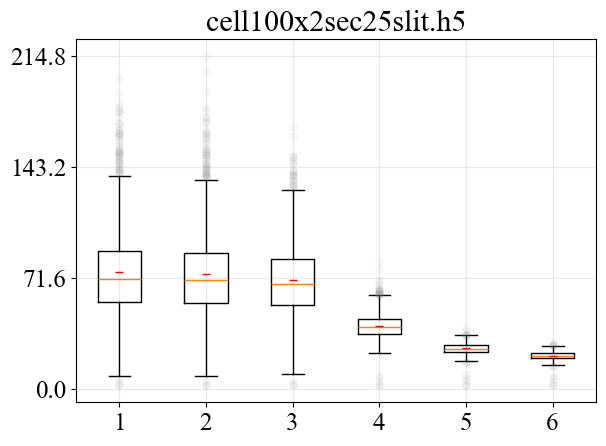

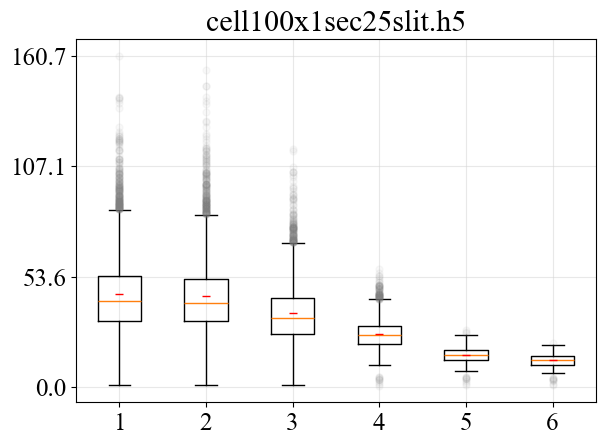

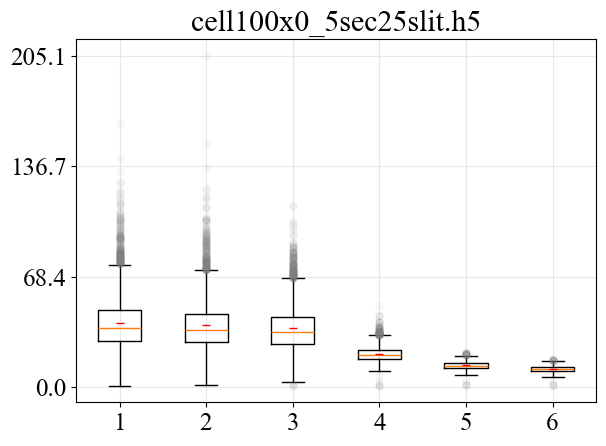

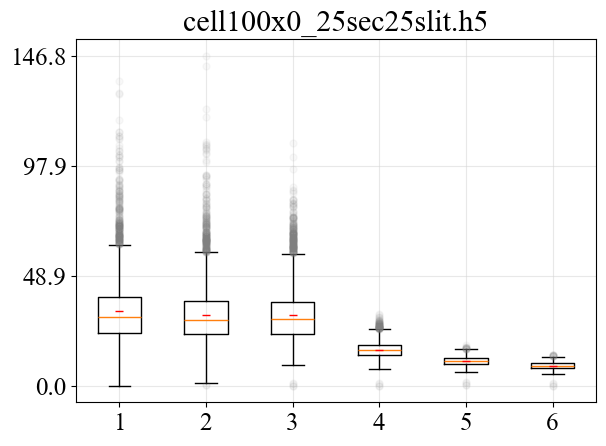

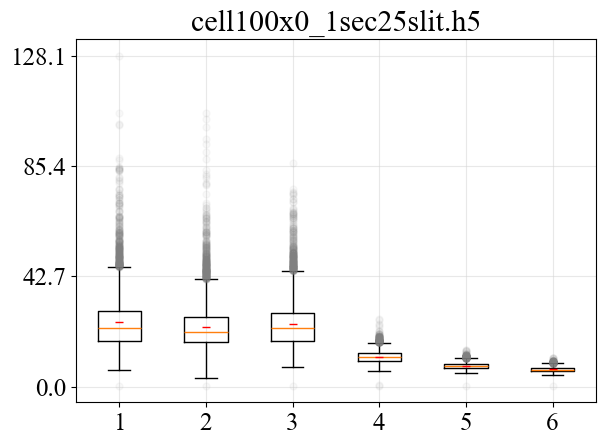

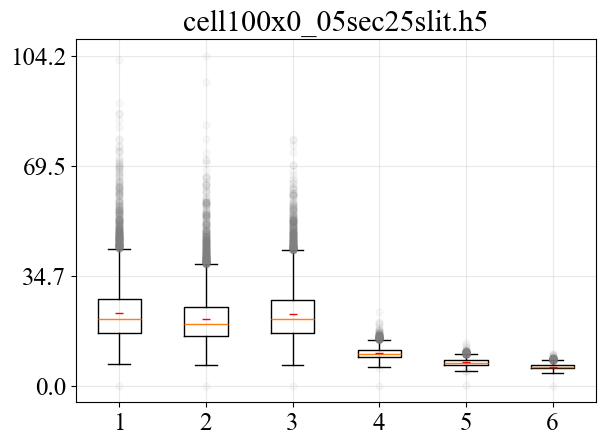

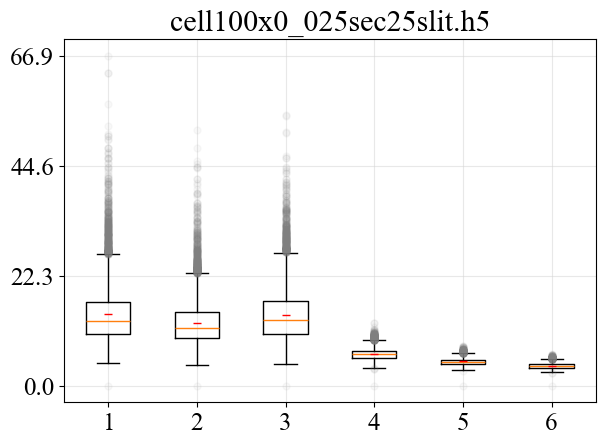

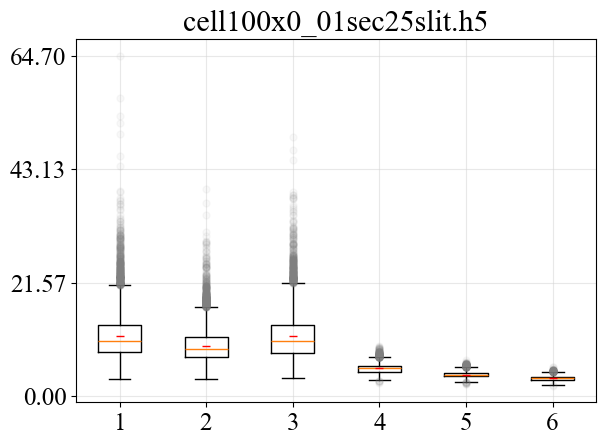

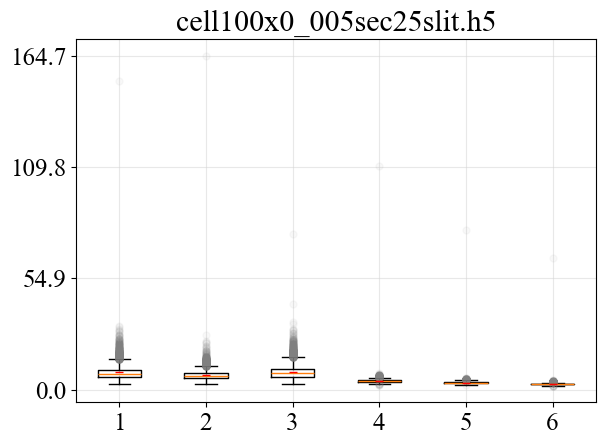

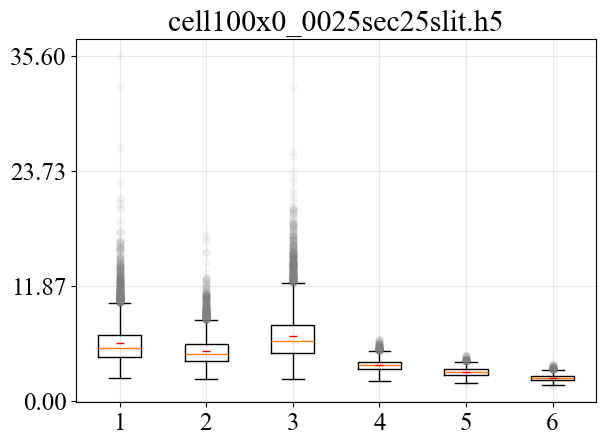

In [17]:
model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Savitzky-Golay", "Raw"]
flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}

for k in SNR_metrics.keys():
    
    plt.boxplot(np.array(SNR_metrics[k]),
                #labels = model_names,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
               )
    plt.title(k)
    num_ticks = 4
    max_ = np.max(SNR_metrics[k])
    ticks = np.linspace(0, max_, num_ticks)
    plt.yticks(ticks)
    #plt.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    plt.tight_layout() # Improves spacing between plots to prevent overlap
    plt.show()

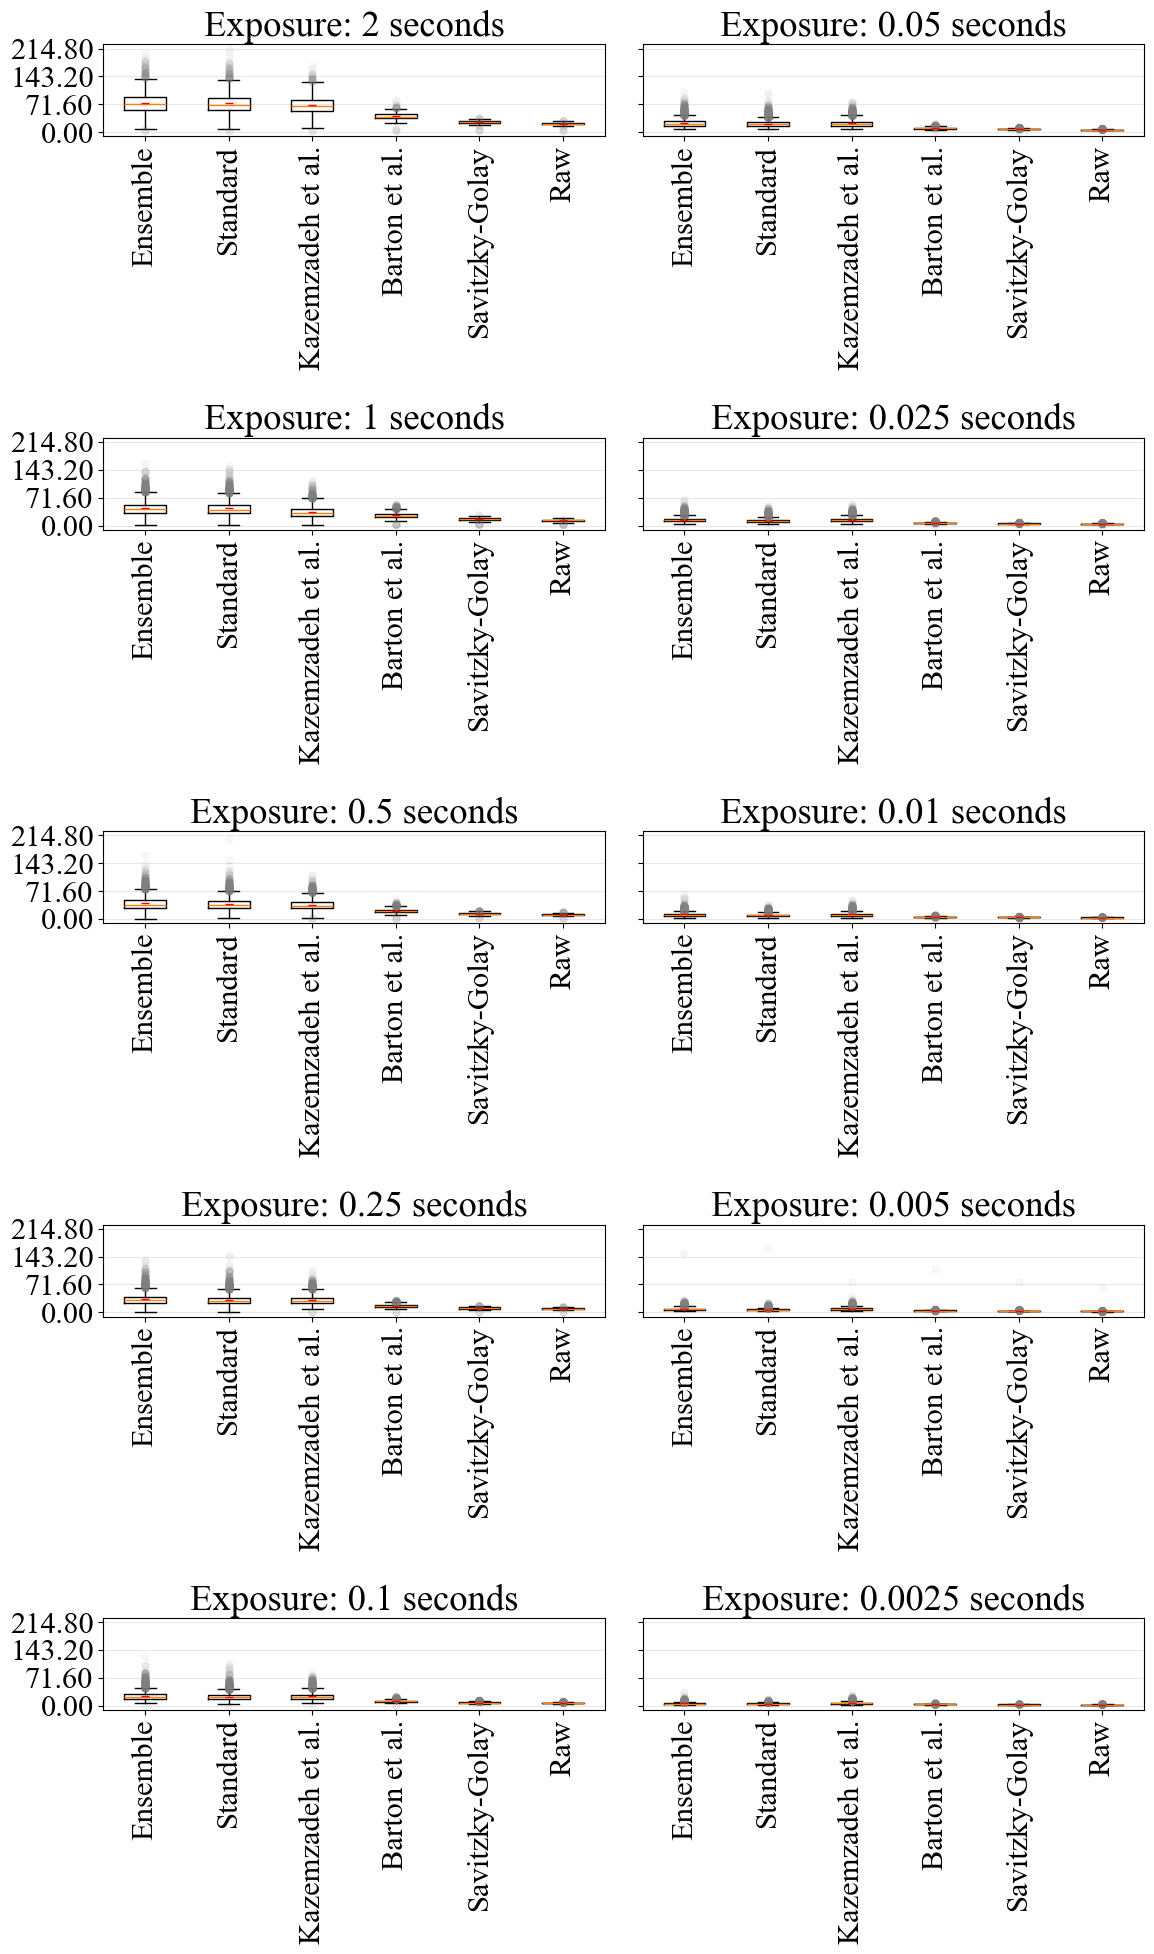

In [22]:
plt.rcParams.update({'font.size': 22})
plt.rcParams["font.family"] = "Times New Roman"
model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Barton et al.", "Savitzky-Golay", "Raw"]

fig, ax = plt.subplots(nrows = 5, ncols = 2, figsize = (12, 20), sharey = True)

x_counter = 0
y_counter = 0

for d, n in zip(reversed(data), reversed(data_names)):
        
    x = x_counter
    y = y_counter
    # Boxplots for SNR
    flier_props = dict(marker='o', markerfacecolor='gray', alpha = 0.05, markersize=5,
                  linestyle='none', markeredgecolor="gray")
    mean_props = {"marker": "_", 'markerfacecolor': "Red", 'markeredgecolor': "Red"}
    ax[y][x].boxplot(np.array(SNR_metrics[n]),
                  #labels = model_names,
                  showmeans=True, 
                  flierprops = flier_props,
                  meanprops= mean_props,
               #showfliers = False
                 )
    title =  n[8: n.index("s")]
    title = title.replace("_", ".")
    
    ax[y][x].set_title("Exposure: " + title + " seconds")
    max_ = np.max(SNR_metrics[data_names[-1]])
    min_ = 0
    num_ticks = 4
    ticks = np.linspace(min_, max_, num_ticks)
    ax[y][x].set_yticks(ticks)
    ax[y][x].yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax[y][x].yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)
    ax[y][x].set_xticklabels(model_names, rotation = 90)
    fig.tight_layout() # Improves spacing between plots to prevent overlap

    y_counter += 1
    if y_counter == 5:
        x_counter += 1
        y_counter = 0
plt.savefig(img_path + "Boxplots.png", format="png", dpi=1200, bbox_inches = "tight")
plt.show()

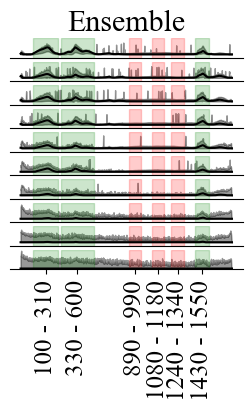

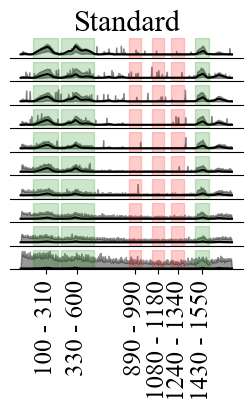

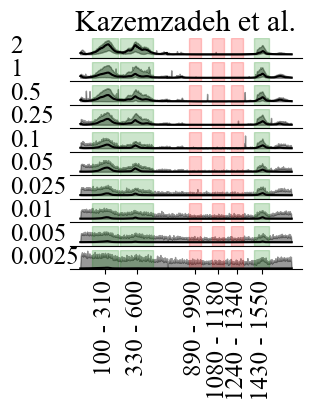

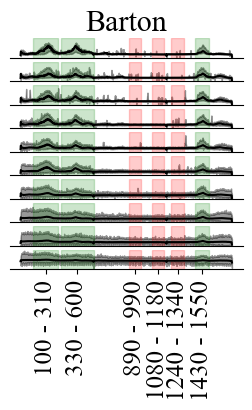

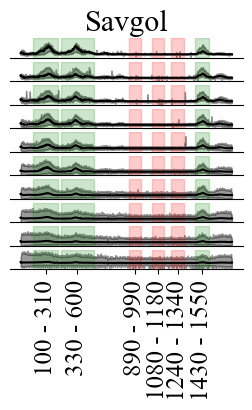

In [20]:
plt.rcParams.update({'font.size': 18})
plt.rcParams["font.family"] = "Times New Roman"

model_names = ["Ensemble", "Standard", "Kazemzadeh et al.", "Barton", "Savgol"]
name_ind = -1
for exposure_preds in [ensemble_preds, standard_preds, casc_preds, barton_preds, savgol_preds]:
    name_ind += 1
    fig, axs = plt.subplots(len(data_names), figsize = (3, 3), sharex=False, sharey=False)
    axs[0].set_title(model_names[name_ind])
    
    for en, n in enumerate(np.flip(data_names)):
        dn = np.squeeze(np.copy(data[-(en+1)]))
        preds = exposure_preds[n]

        if model_names[name_ind] == "Ensemble":
            denoised = ensemble_components[n][-1]
        elif model_names[name_ind] == "Standard":
            denoised = standard_components[n][-1]
        elif model_names[name_ind] == "Kazemzadeh et al.":
            denoised = casc_peaks[n]
        else:
            denoised = dn - np.array(preds) - casc_bl[n]

        # Plot the percentiles on each frequency
        axs[en].fill_between(np.arange(1738), np.percentile(denoised, 0, axis = 0), np.percentile(denoised, 100, axis = 0), alpha = 0.4,
                             color = "Black")
        
        # Plot the mean vector of the data class
        axs[en].plot(np.median(denoised, axis = 0), color = "Black")
    
        for region in noise_regions:
            axs[en].axvspan(region[0], region[-1], color = "red", alpha = 0.2)
    
        for region in signal_regions:
            axs[en].axvspan(region[0], region[-1], color = "green", alpha = 0.2)
    

        if model_names[name_ind] == "Kazemzadeh et al.":
            axs[en].set_ylabel(np.flip(y_labels)[en], rotation=0, loc='bottom', labelpad=43)
            
        axs[en].set_xticks([])
        axs[en].set_yticks([])
        axs[en].set_ylim(-0.3, 1.3)
        axs[en].spines['left'].set_visible(False)
        axs[en].spines['right'].set_visible(False)
        axs[en].spines['top'].set_visible(False)

    plt.autoscale() 

    x_ticks = np.ravel([np.mean([np.min(reg), np.max(reg)]) for reg in joined_regions])
    x_labels = [str(np.min(reg)) + " - " + str(np.max(reg)) for reg in joined_regions]
    plt.xticks(x_ticks, x_labels, rotation = 90)
    plt.savefig(img_path + model_names[name_ind] + "Distro.png", format="png", dpi=1200, bbox_inches = "tight")
    plt.show()